# Signal denoising

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In [1]:
import math

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from cvxpylayers.torch import CvxpyLayer

import latexify
latexify.latexify()

torch.set_default_tensor_type(torch.DoubleTensor)
%matplotlib inline

In [2]:
torch.random.manual_seed(0)
np.random.seed(0)
N_train = 500
N_val = 100
n = 100
m = 100
n_regions = 100
n_points_per_region = n // n_regions
Sigma_sqrt = 0.1*np.random.randn(n, n)
Sigma = Sigma_sqrt.T @ Sigma_sqrt
normal = torch.distributions.MultivariateNormal(loc=torch.zeros(n), covariance_matrix=torch.tensor(Sigma))

inputs = []
outputs = []
eval_pts = torch.linspace(0, 2*math.pi, n)
for i in range(N_train + N_val):
    b = np.random.uniform(low=1, high=3)
    y = torch.cos(b*eval_pts)
    x = y.clone()
    x += normal.sample()
    inputs.append(x)
    outputs.append(y)

inputs = torch.stack(inputs)
outputs = torch.stack(outputs)

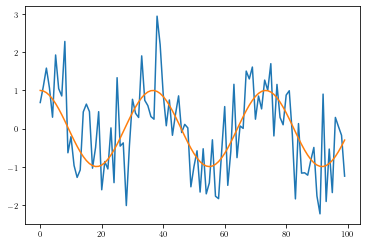

In [3]:
idx = np.random.randint(low=0, high=N_train+N_val)
plt.plot(inputs[idx])
plt.plot(outputs[idx])

In [4]:
X_train = inputs[:N_train]
Y_train = outputs[:N_train]

X_val = inputs[N_train:]
Y_val = outputs[N_train:]

In [5]:
def create_layer():
    y_cp = cp.Variable(n)
    x_minus_y = cp.Variable(n)
    
    x_param = cp.Parameter(n)
    theta_param = cp.Parameter((n, n))
    lambda_param = cp.Parameter(pos=True)
    objective = (
        cp.sum_squares(theta_param @ x_minus_y) +
        lambda_param*cp.sum_squares(cp.diff(y_cp))
    )
    constraints = [
        x_minus_y == x_param - y_cp
    ]
    problem = cp.Problem(cp.Minimize(objective), constraints)
    layer = CvxpyLayer(
        problem,
        parameters=[x_param, theta_param, lambda_param],
        variables=[y_cp])
    return layer
    

layer = create_layer()

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from cvxpylayers.torch import CvxpyLayer

torch.set_default_dtype(torch.double)

from tqdm.notebook import tqdm


def fit(loss, params, X, Y, Xval, Yval, batch_size=128, lr=1e-3, epochs=100, verbose=False, print_every=1, callback=None):
    """

    Arguments:
        loss: given x and y in batched form, evaluates loss.
        params: list of parameters to optimize.
        X: input data, torch tensor.
        Y: output data, torch tensor.
        Xval: input validation data, torch tensor.
        Yval: output validation data, torch tensor.
    """

    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(params, lr=lr)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        if callback is not None:
            callback()
            
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
        if verbose and epoch % print_every == 0:
            print("val loss %03d | %3.5f" % (epoch + 1, val_losses[-1]))

        batch = 1
        train_losses.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if verbose and epoch % print_every == 0:
                print("batch %03d / %03d | %3.5f" %
                      (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
    return val_losses, train_losses

In [7]:
theta_tch = torch.eye(n, requires_grad=True)
lambda_tch = torch.tensor(0.5, requires_grad=True)
params = [theta_tch, lambda_tch]

def loss_fn(X, actual):
    preds = layer(X, theta_tch, lambda_tch)[0]
    mse_per_example = (preds - actual).pow(2).mean(axis=1)
    return mse_per_example.mean()

In [8]:
val_losses, train_losses =  fit(
    loss_fn, params, X_train, Y_train, X_val, Y_val, lr=1e-2, batch_size=64,
    epochs=150, verbose=True, print_every=1)

val loss 001 | 0.38692
batch 001 / 008 | 0.39239
batch 002 / 008 | 0.36840
batch 003 / 008 | 0.35093
batch 004 / 008 | 0.33016
batch 005 / 008 | 0.31447
batch 006 / 008 | 0.30035
batch 007 / 008 | 0.28926
batch 008 / 008 | 0.27819
val loss 002 | 0.18375
batch 001 / 008 | 0.15358
batch 002 / 008 | 0.15582
batch 003 / 008 | 0.15099
batch 004 / 008 | 0.14711
batch 005 / 008 | 0.14485
batch 006 / 008 | 0.14298
batch 007 / 008 | 0.14213
batch 008 / 008 | 0.14041
val loss 003 | 0.12666
batch 001 / 008 | 0.10916
batch 002 / 008 | 0.10473
batch 003 / 008 | 0.10236
batch 004 / 008 | 0.10073
batch 005 / 008 | 0.09937
batch 006 / 008 | 0.09847
batch 007 / 008 | 0.09814
batch 008 / 008 | 0.09792
val loss 004 | 0.09905
batch 001 / 008 | 0.08246
batch 002 / 008 | 0.07950
batch 003 / 008 | 0.07900
batch 004 / 008 | 0.07947
batch 005 / 008 | 0.07868
batch 006 / 008 | 0.07844
batch 007 / 008 | 0.07735
batch 008 / 008 | 0.07601
val loss 005 | 0.08335
batch 001 / 008 | 0.06124
batch 002 / 008 | 0.06315
b

batch 005 / 008 | 0.01487
batch 006 / 008 | 0.01512
batch 007 / 008 | 0.01522
batch 008 / 008 | 0.01525
val loss 037 | 0.01917
batch 001 / 008 | 0.01463
batch 002 / 008 | 0.01397
batch 003 / 008 | 0.01414
batch 004 / 008 | 0.01396
batch 005 / 008 | 0.01424
batch 006 / 008 | 0.01450
batch 007 / 008 | 0.01477
batch 008 / 008 | 0.01487
val loss 038 | 0.01858
batch 001 / 008 | 0.01432
batch 002 / 008 | 0.01392
batch 003 / 008 | 0.01387
batch 004 / 008 | 0.01400
batch 005 / 008 | 0.01403
batch 006 / 008 | 0.01437
batch 007 / 008 | 0.01447
batch 008 / 008 | 0.01464
val loss 039 | 0.01842
batch 001 / 008 | 0.01260
batch 002 / 008 | 0.01285
batch 003 / 008 | 0.01315
batch 004 / 008 | 0.01376
batch 005 / 008 | 0.01413
batch 006 / 008 | 0.01416
batch 007 / 008 | 0.01410
batch 008 / 008 | 0.01424
val loss 040 | 0.01790
batch 001 / 008 | 0.01294
batch 002 / 008 | 0.01316
batch 003 / 008 | 0.01328
batch 004 / 008 | 0.01315
batch 005 / 008 | 0.01300
batch 006 / 008 | 0.01347
batch 007 / 008 | 0.0137

batch 001 / 008 | 0.01136
batch 002 / 008 | 0.01150
batch 003 / 008 | 0.01128
batch 004 / 008 | 0.01113
batch 005 / 008 | 0.01110
batch 006 / 008 | 0.01136
batch 007 / 008 | 0.01151
batch 008 / 008 | 0.01146
val loss 073 | 0.01481
batch 001 / 008 | 0.01075
batch 002 / 008 | 0.01100
batch 003 / 008 | 0.01124
batch 004 / 008 | 0.01103
batch 005 / 008 | 0.01097
batch 006 / 008 | 0.01101
batch 007 / 008 | 0.01119
batch 008 / 008 | 0.01138
val loss 074 | 0.01502
batch 001 / 008 | 0.01020
batch 002 / 008 | 0.00974
batch 003 / 008 | 0.01030
batch 004 / 008 | 0.01066
batch 005 / 008 | 0.01078
batch 006 / 008 | 0.01117
batch 007 / 008 | 0.01145
batch 008 / 008 | 0.01156
val loss 075 | 0.01476
batch 001 / 008 | 0.01017
batch 002 / 008 | 0.01035
batch 003 / 008 | 0.01075
batch 004 / 008 | 0.01082
batch 005 / 008 | 0.01095
batch 006 / 008 | 0.01124
batch 007 / 008 | 0.01144
batch 008 / 008 | 0.01145
val loss 076 | 0.01475
batch 001 / 008 | 0.01047
batch 002 / 008 | 0.01072
batch 003 / 008 | 0.0109

batch 006 / 008 | 0.01110
batch 007 / 008 | 0.01129
batch 008 / 008 | 0.01136
val loss 108 | 0.01440
batch 001 / 008 | 0.01061
batch 002 / 008 | 0.01012
batch 003 / 008 | 0.01056
batch 004 / 008 | 0.01081
batch 005 / 008 | 0.01113
batch 006 / 008 | 0.01116
batch 007 / 008 | 0.01122
batch 008 / 008 | 0.01125
val loss 109 | 0.01419
batch 001 / 008 | 0.00972
batch 002 / 008 | 0.01037
batch 003 / 008 | 0.01043
batch 004 / 008 | 0.01042
batch 005 / 008 | 0.01077
batch 006 / 008 | 0.01089
batch 007 / 008 | 0.01102
batch 008 / 008 | 0.01104
val loss 110 | 0.01423
batch 001 / 008 | 0.01052
batch 002 / 008 | 0.01062
batch 003 / 008 | 0.01064
batch 004 / 008 | 0.01050
batch 005 / 008 | 0.01065
batch 006 / 008 | 0.01105
batch 007 / 008 | 0.01101
batch 008 / 008 | 0.01103
val loss 111 | 0.01405
batch 001 / 008 | 0.01132
batch 002 / 008 | 0.01063
batch 003 / 008 | 0.01045
batch 004 / 008 | 0.01063
batch 005 / 008 | 0.01081
batch 006 / 008 | 0.01103
batch 007 / 008 | 0.01111
batch 008 / 008 | 0.0110

batch 002 / 008 | 0.00982
batch 003 / 008 | 0.00994
batch 004 / 008 | 0.00980
batch 005 / 008 | 0.00971
batch 006 / 008 | 0.00993
batch 007 / 008 | 0.01024
batch 008 / 008 | 0.01028
val loss 144 | 0.01371
batch 001 / 008 | 0.01017
batch 002 / 008 | 0.01005
batch 003 / 008 | 0.01001
batch 004 / 008 | 0.01032
batch 005 / 008 | 0.01016
batch 006 / 008 | 0.01027
batch 007 / 008 | 0.01046
batch 008 / 008 | 0.01049
val loss 145 | 0.01373
batch 001 / 008 | 0.01025
batch 002 / 008 | 0.01013
batch 003 / 008 | 0.01020
batch 004 / 008 | 0.01040
batch 005 / 008 | 0.01009
batch 006 / 008 | 0.01028
batch 007 / 008 | 0.01044
batch 008 / 008 | 0.01048
val loss 146 | 0.01341
batch 001 / 008 | 0.00992
batch 002 / 008 | 0.00991
batch 003 / 008 | 0.01001
batch 004 / 008 | 0.01009
batch 005 / 008 | 0.01026
batch 006 / 008 | 0.01022
batch 007 / 008 | 0.01029
batch 008 / 008 | 0.01037
val loss 147 | 0.01362
batch 001 / 008 | 0.00984
batch 002 / 008 | 0.00971
batch 003 / 008 | 0.00974
batch 004 / 008 | 0.0100

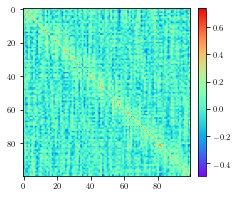

In [9]:
plt.figure(figsize=(3.4, 3.4))
plt.imshow(theta_tch.detach().numpy(), cmap='rainbow')
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

In [10]:
lambda_tch

tensor(1.4806, requires_grad=True)

In [11]:
with torch.no_grad():
    val_preds = layer(X_val, theta_tch, lambda_tch)[0]

In [12]:
with torch.no_grad():
    train_preds = layer(X_train, theta_tch, lambda_tch)[0]

In [13]:
y_cp = cp.Variable(n)
x_minus_y = cp.Variable(n)

x_param = cp.Parameter(n)
lambda_param = cp.Parameter(pos=True)

objective = (
    cp.sum_squares(x_param - y_cp) +
    lambda_param*cp.sum_squares(cp.diff(y_cp))
)
problem = cp.Problem(cp.Minimize(objective))
one_param_layer = CvxpyLayer(problem=problem, parameters=[x_param, lambda_param], variables=[y_cp])

In [14]:
lambda_values = torch.linspace(0, 20, 10)
best_lambda = None
lowest_loss = np.inf
for value in tqdm(lambda_values):
    print('lambda ', value)
    preds = one_param_layer(X_train, value, 
        solver_args = {
            "acceleration_lookback": 0,
            "max_iters": 10000
        })[0]
    mse_per_example = (preds - Y_train).pow(2).mean(axis=1)
    mse = mse_per_example.mean()
    print('mse', mse)
    if mse < lowest_loss:
        print('lowest mse yet')
        lowest_loss = mse
        best_lambda = value

lambda  tensor(0.)
mse tensor(0.9800)
lowest mse yet
lambda  tensor(2.2222)
mse tensor(0.1784)
lowest mse yet
lambda  tensor(4.4444)
mse tensor(0.1267)
lowest mse yet
lambda  tensor(6.6667)
mse tensor(0.1068)
lowest mse yet
lambda  tensor(8.8889)
mse tensor(0.0972)
lowest mse yet
lambda  tensor(11.1111)
mse tensor(0.0924)
lowest mse yet
lambda  tensor(13.3333)
mse tensor(0.0904)
lowest mse yet
lambda  tensor(15.5556)
mse tensor(0.0901)
lowest mse yet
lambda  tensor(17.7778)
mse tensor(0.0909)
lambda  tensor(20.)
mse tensor(0.0926)



In [15]:
print(best_lambda)

tensor(15.5556)


In [16]:
print(lowest_loss)

tensor(0.0901)


In [17]:
one_param_preds = one_param_layer(X_val, best_lambda, 
        solver_args = {
            "acceleration_lookback": 0,
            "max_iters": 10000
        })[0]
mse_per_example = (one_param_preds - Y_val).pow(2).mean(axis=1)
one_param_mse = mse_per_example.mean()
print(one_param_mse)

tensor(0.0897)


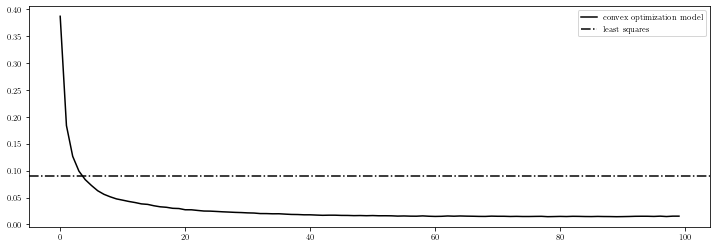

In [18]:
%load_ext autoreload
%autoreload 2
import latexify
latexify.latexify()

plt.figure(figsize=(10., 3.5))
ax = plt.gca()
plt.plot(val_losses[:100], color='k', label='convex optimization model')
ax.axhline(one_param_mse, color='k', linestyle='-.', label='least squares')
plt.legend()
plt.tight_layout()

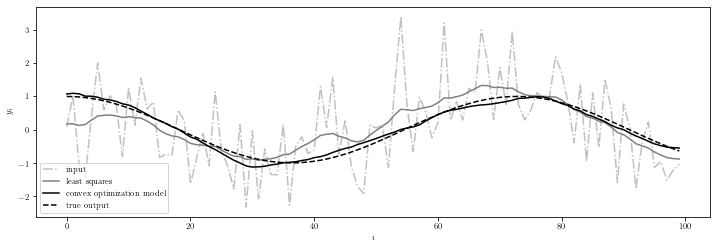

In [19]:
idx = 1
plt.figure(figsize=(10., 3.5))
plt.plot(X_val[idx], label='input', color='silver', linestyle='-.')
plt.plot(one_param_preds[idx], label='least squares', color='gray', linestyle='-',)
plt.plot(val_preds[idx], label='convex optimization model', color='k', linestyle='-')
plt.plot(Y_val[idx], label='true output', linestyle='--', color='k')
plt.xlabel('$i$')
plt.ylabel('$y_i$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()